In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import glob 
from segmentation_unet import SegmentationUNet
import os 
import tifffile
from datasets.dendrites_dataset import DendriticFActinDataset

# RAW_PATH = "/home/frederic/DRAFT/static/test/raw"
RAW_PATH = "/home-local/Frederic/image-generation/raw"
DATASET_PATH = "/home-local/Frederic/Datasets/DendriticFActinDataset"
files = glob.glob(os.path.join(DATASET_PATH, "test", "*.tif"))

dataset = DendriticFActinDataset(files=files, split="test", coordinates_path="/home-local/Frederic/Datasets/DendriticFActinDataset-exported")

Found 335 coordinates


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_unet(checkpoint_unet: str = "/home-local/Frederic/baselines/pretrained-unet-01/params.net"):
    unet = SegmentationUNet(in_channels=1, out_channels=2)
    unet.load_state_dict(torch.load(checkpoint_unet, map_location="cpu"))
    return unet

unet = load_unet()
unet.eval()
unet.to(DEVICE)


SegmentationUNet(
  (input_conv): DoubleConvolver(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (contracting_path): ModuleList(
    (0): Contracter(
      (conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConvolver(
          (conv): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

## Searching for optimal thresholds

 17%|█▋        | 17/100 [00:05<00:24,  3.37it/s]

100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


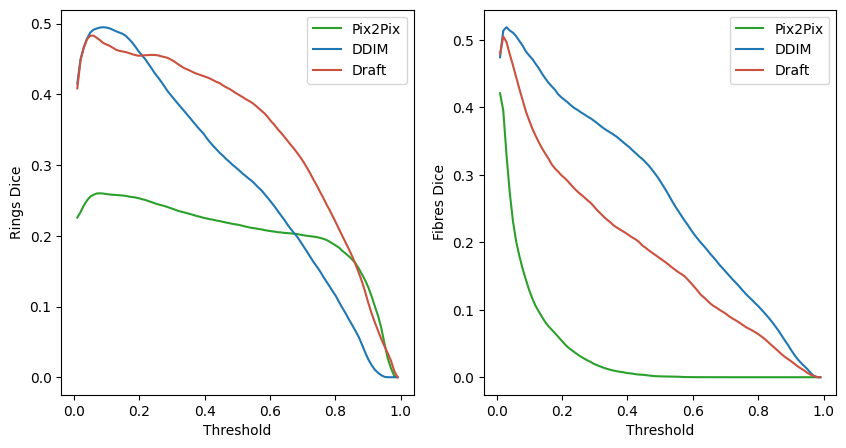

Best DDIM ring threshold: 0.08919191919191918
Best DDIM fibre threshold: 0.029797979797979796
Best Draft ring threshold: 0.049595959595959596
Best Draft fibre threshold: 0.0198989898989899
Best Pix2Pix ring threshold: 0.07929292929292929
Best Pix2Pix fibre threshold: 0.01


In [3]:
from tiffwrapper import make_composite
from tqdm import tqdm, trange

generated_files = glob.glob(os.path.join(RAW_PATH, "*.tif"))
def retrieve_generated(index: int, path: str):
    pix2pix_file = os.path.join(path, f"sample_{index}_pix2pix.tif")
    ddim_file = os.path.join(path, f"sample_{index}_ddim.tif")
    draft_file = os.path.join(path, f"sample_{index}_draft.tif")
    confocal_file = os.path.join(path, f"sample_{index}_confocal.tif")
    sted_file = os.path.join(path, f"sample_{index}_sted.tif")
    segmentation_file = os.path.join(path, f"sample_{index}_segmentation.tif")
    return pix2pix_file,ddim_file, draft_file, confocal_file, sted_file, segmentation_file

def compute_mask(img: np.ndarray, device: torch.device):
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        mask = unet(img)
    return mask.cpu().numpy().squeeze()

def compute_dice(pred: np.ndarray, gt: np.ndarray):
    dice_per_channel = []
    for ch in range(pred.shape[0]):
        if np.count_nonzero(gt[ch]) == 0:
            dice_per_channel.append(-1)
        else:
            pred_ch = pred[ch, ...]
            gt_ch = gt[ch, ...]
            intersection = np.logical_and(pred_ch, gt_ch)
            union = np.logical_or(pred_ch, gt_ch)
            dice = 2 * intersection.sum() / (pred_ch.sum() + gt_ch.sum())
            dice_per_channel.append(dice)
    return dice_per_channel


thresholds = np.linspace(0.01, 0.99, 100)

ddim_rings_dice = [] 
draft_rings_dice = []
ddim_fibres_dice = []
draft_fibres_dice = []
pix2pix_rings_dice = []
pix2pix_fibres_dice = []

for t in tqdm(thresholds):
    ddim_current_rings_dice = []
    ddim_current_fibres_dice = []
    draft_current_rings_dice = []
    draft_current_fibres_dice = []
    pix2pix_current_rings_dice = []
    pix2pix_current_fibres_dice = []
    for i in range(26):
        pix2pix_file, ddim_file, draft_file, confocal_file, sted_file, segmentation_file = retrieve_generated(i, RAW_PATH)
        ground_truth = tifffile.imread(segmentation_file)

        pix2pix_gen = np.clip(tifffile.imread(pix2pix_file), 0, 1)
        pix2pix_mask = compute_mask(pix2pix_gen, DEVICE)
        pix2pix_binary_mask = pix2pix_mask > t
        pix2pix_rings, pix2pix_fibres = compute_dice(pix2pix_binary_mask, ground_truth)
        if pix2pix_rings != -1:
            pix2pix_current_rings_dice.append(pix2pix_rings)
        if pix2pix_fibres != -1:
            pix2pix_current_fibres_dice.append(pix2pix_fibres)

        ddim_gen = np.clip(tifffile.imread(ddim_file), 0, 1)
        ddim_mask = compute_mask(ddim_gen, DEVICE) 
        ddim_binary_mask = ddim_mask > t
        ddim_rings, ddim_fibres = compute_dice(ddim_binary_mask, ground_truth)
        if ddim_rings != -1:
            ddim_current_rings_dice.append(ddim_rings)
        if ddim_fibres != -1:
            ddim_current_fibres_dice.append(ddim_fibres)
        # ddim_mask_rgb = make_composite(ddim_mask, luts=['green', 'magenta'], ranges=[(0,1), (0,1)])

        draft_gen = np.clip(tifffile.imread(draft_file), 0, 1)
        draft_mask = compute_mask(draft_gen, DEVICE) 
        draft_binary_mask = draft_mask > t
        draft_rings, draft_fibres = compute_dice(draft_binary_mask, ground_truth)

        if draft_rings != -1:
            draft_current_rings_dice.append(draft_rings)
        if draft_fibres != -1:
            draft_current_fibres_dice.append(draft_fibres)
        # draft_mask_rgb = make_composite(draft_mask, luts=['green', 'magenta'], ranges=[(0,1), (0,1)])

        confocal_gen = np.clip(tifffile.imread(confocal_file), 0, 1)
        sted = np.clip(tifffile.imread(sted_file), 0, 1)
        # segmentation_gen = tifffile.imread(segmentation_file)
    ddim_rings_dice.append(np.mean(ddim_current_rings_dice)) 
    ddim_fibres_dice.append(np.mean(ddim_current_fibres_dice))
    draft_rings_dice.append(np.mean(draft_current_rings_dice))
    draft_fibres_dice.append(np.mean(draft_current_fibres_dice))
    pix2pix_rings_dice.append(np.mean(pix2pix_current_rings_dice))
    pix2pix_fibres_dice.append(np.mean(pix2pix_current_fibres_dice))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(thresholds, pix2pix_rings_dice, label="Pix2Pix", color="tab:green")
axs[0].plot(thresholds, ddim_rings_dice, label="DDIM", color="tab:blue")
axs[0].plot(thresholds, draft_rings_dice, label="Draft", color="#CC503E")
axs[0].legend()
axs[1].plot(thresholds, pix2pix_fibres_dice, label="Pix2Pix", color="tab:green")
axs[1].plot(thresholds, ddim_fibres_dice, label="DDIM", color="tab:blue")
axs[1].plot(thresholds, draft_fibres_dice, label="Draft", color="#CC503E")
axs[1].legend()
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("Rings Dice")
axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("Fibres Dice")
plt.show()

BEST_DDIM_RING_THRESHOLD = thresholds[np.argmax(ddim_rings_dice)]
BEST_DDIM_FIBRE_THRESHOLD = thresholds[np.argmax(ddim_fibres_dice)]
BEST_DRAFT_RING_THRESHOLD = thresholds[np.argmax(draft_rings_dice)]
BEST_DRAFT_FIBRE_THRESHOLD = thresholds[np.argmax(draft_fibres_dice)]
BEST_PIX2PIX_RING_THRESHOLD = thresholds[np.argmax(pix2pix_rings_dice)]
BEST_PIX2PIX_FIBRE_THRESHOLD = thresholds[np.argmax(pix2pix_fibres_dice)]

print(f"Best DDIM ring threshold: {BEST_DDIM_RING_THRESHOLD}")
print(f"Best DDIM fibre threshold: {BEST_DDIM_FIBRE_THRESHOLD}")
print(f"Best Draft ring threshold: {BEST_DRAFT_RING_THRESHOLD}")
print(f"Best Draft fibre threshold: {BEST_DRAFT_FIBRE_THRESHOLD}")
print(f"Best Pix2Pix ring threshold: {BEST_PIX2PIX_RING_THRESHOLD}")
print(f"Best Pix2Pix fibre threshold: {BEST_PIX2PIX_FIBRE_THRESHOLD}")

    

  0%|          | 0/26 [00:00<?, ?it/s]

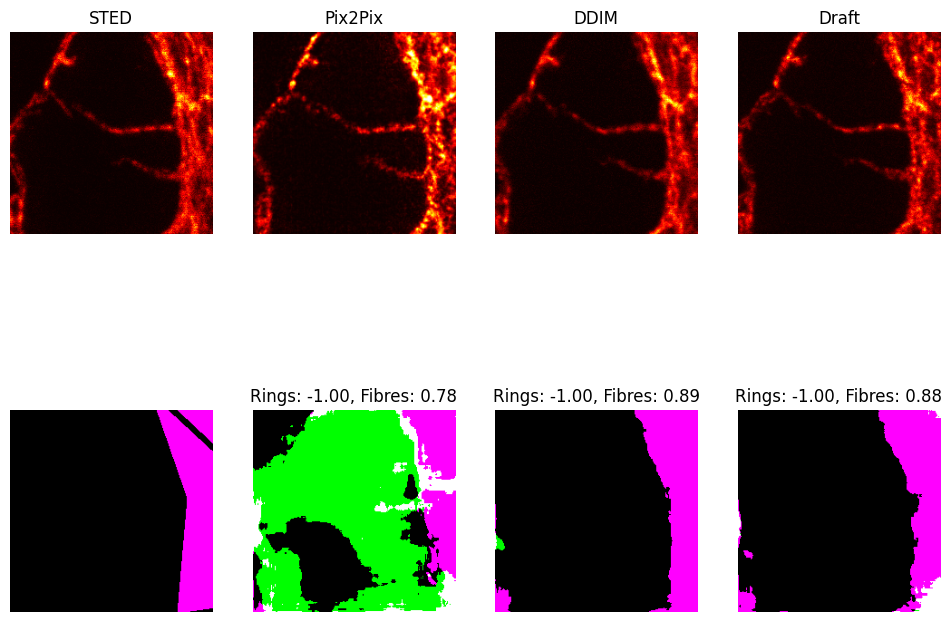

  4%|▍         | 1/26 [00:03<01:22,  3.28s/it]

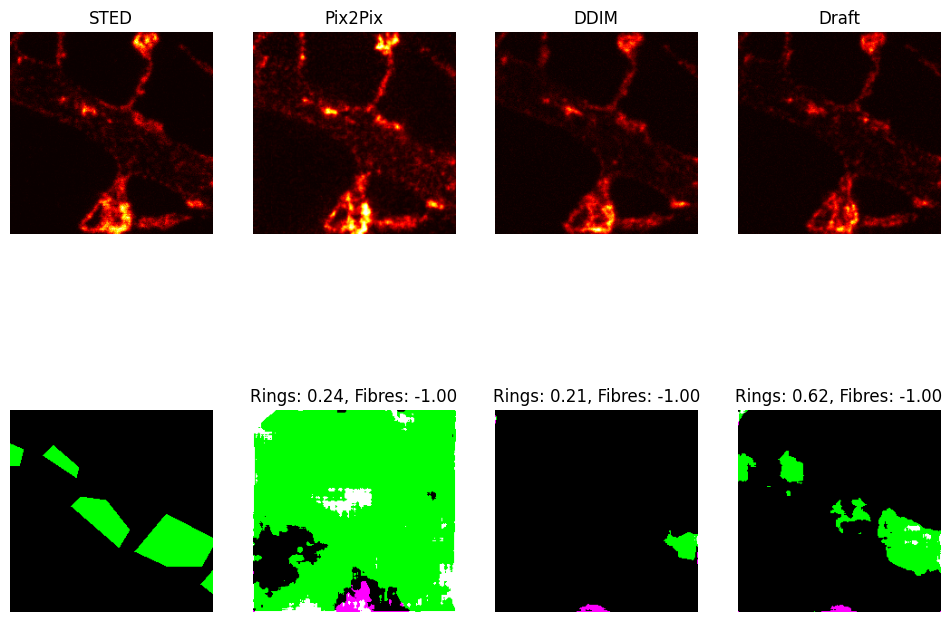

  8%|▊         | 2/26 [00:06<01:12,  3.04s/it]

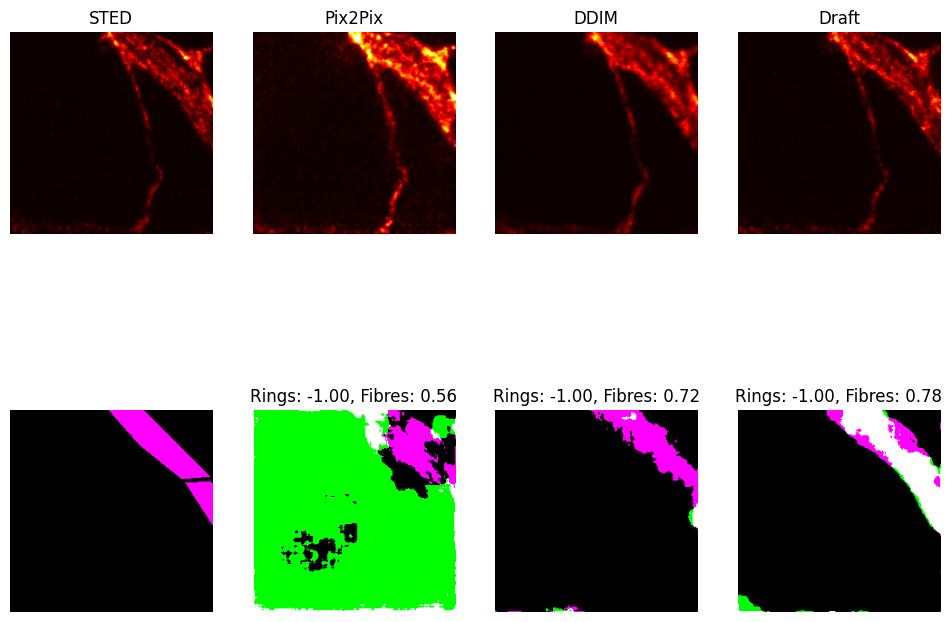

 12%|█▏        | 3/26 [00:09<01:08,  3.00s/it]

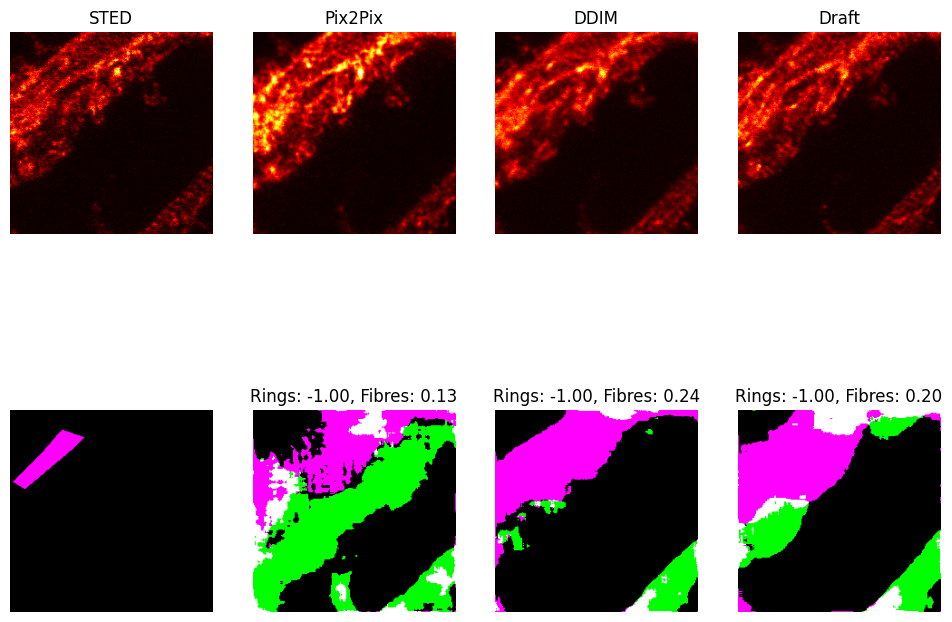

 15%|█▌        | 4/26 [00:12<01:10,  3.19s/it]

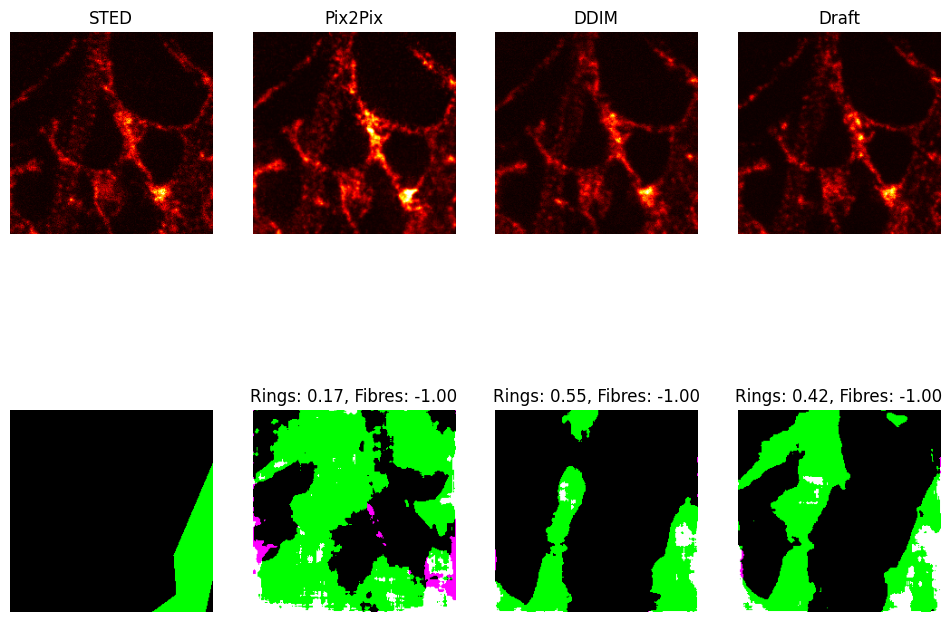

 19%|█▉        | 5/26 [00:16<01:08,  3.29s/it]

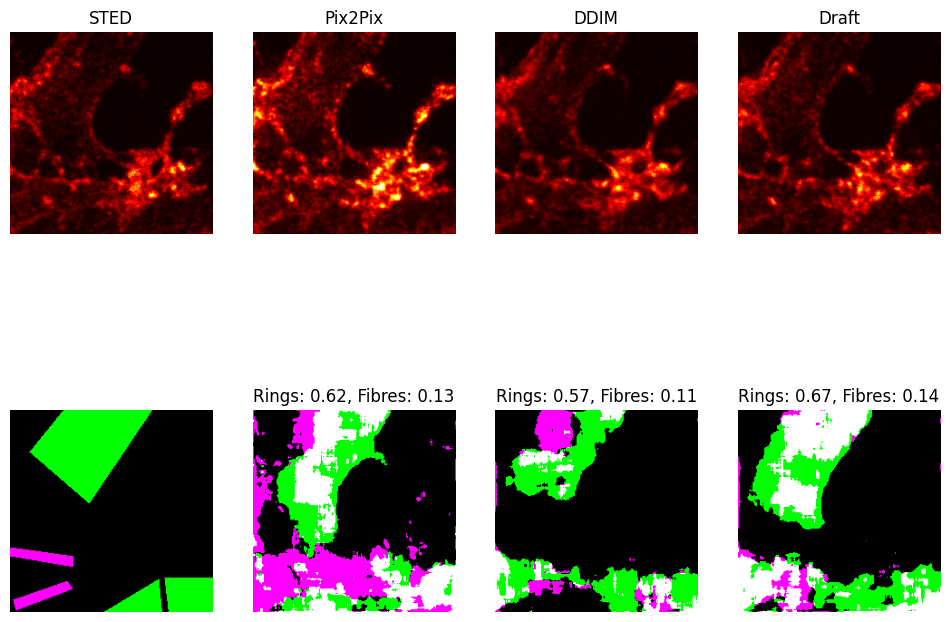

 23%|██▎       | 6/26 [00:19<01:05,  3.29s/it]

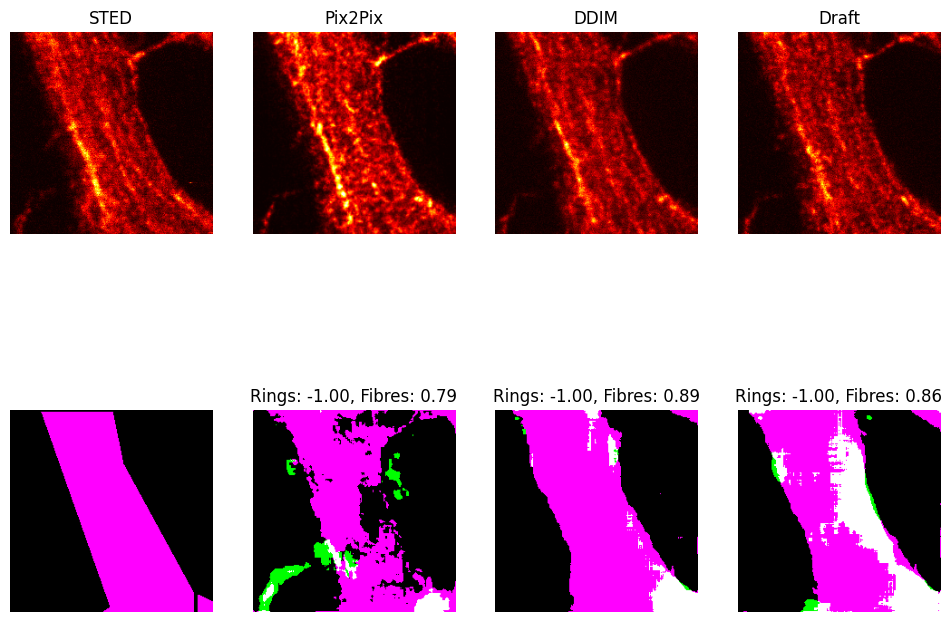

 27%|██▋       | 7/26 [00:22<01:00,  3.21s/it]

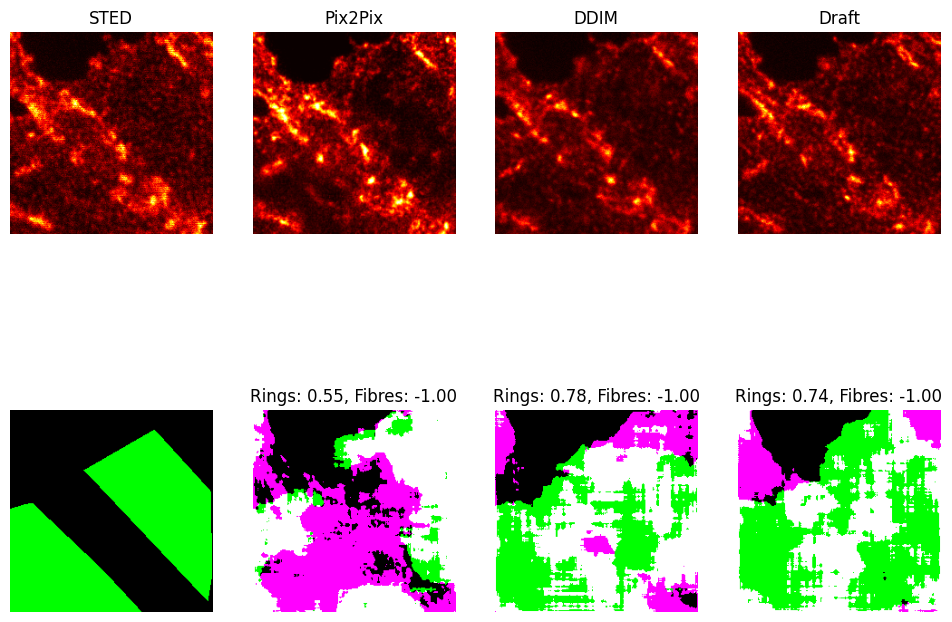

 31%|███       | 8/26 [00:25<00:55,  3.09s/it]

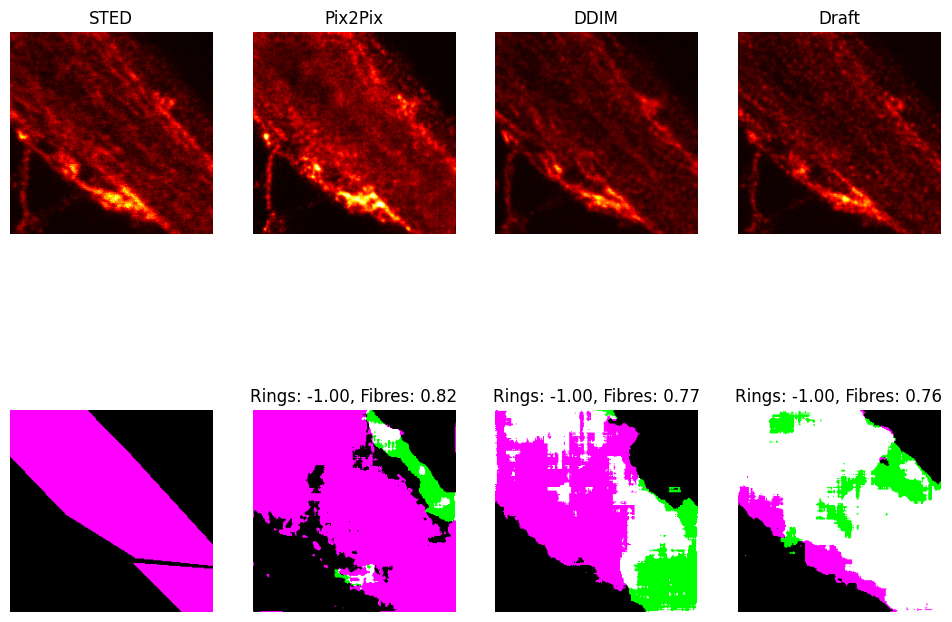

 35%|███▍      | 9/26 [00:28<00:52,  3.08s/it]

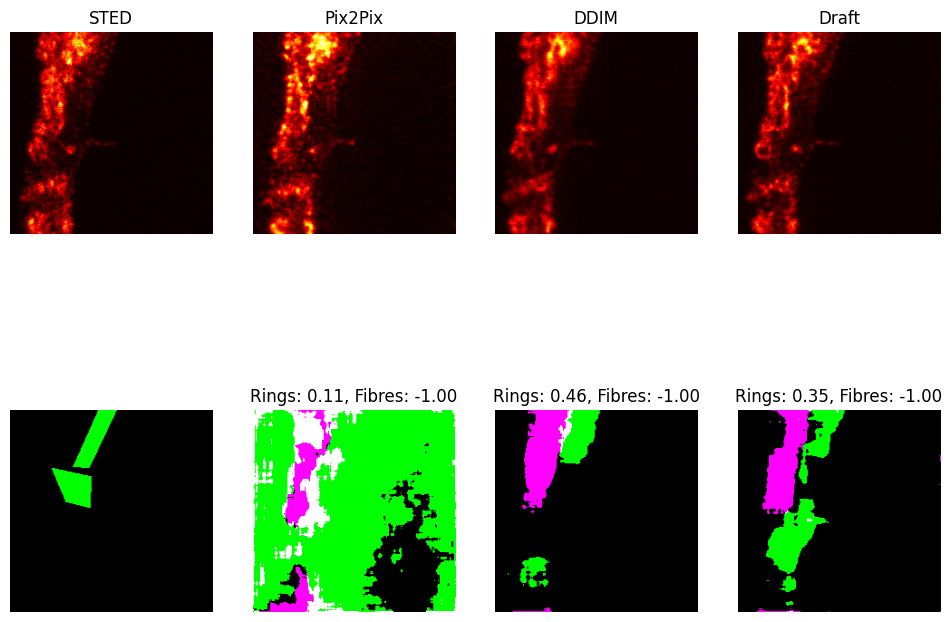

 38%|███▊      | 10/26 [00:31<00:48,  3.03s/it]

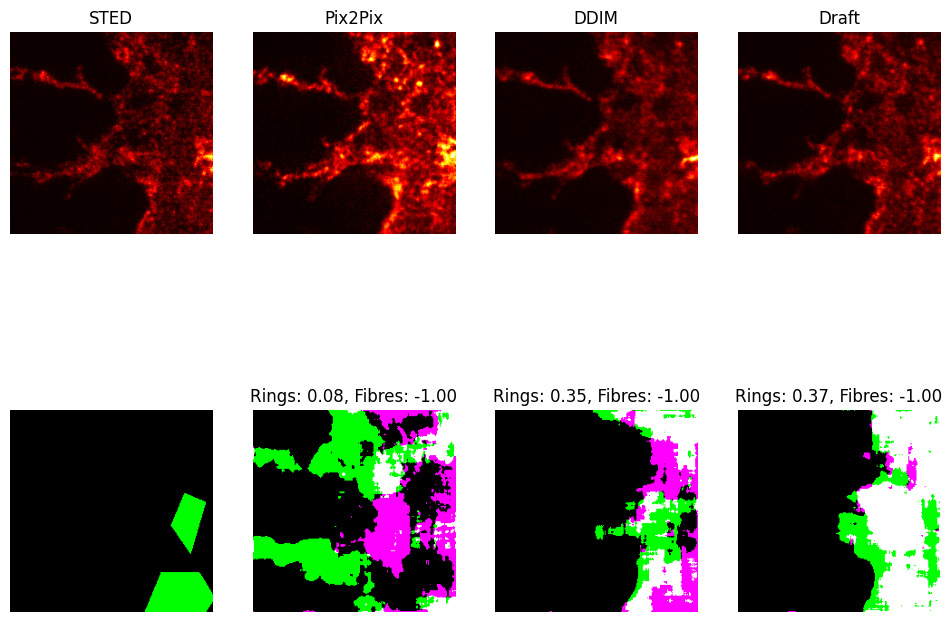

 42%|████▏     | 11/26 [00:34<00:46,  3.07s/it]

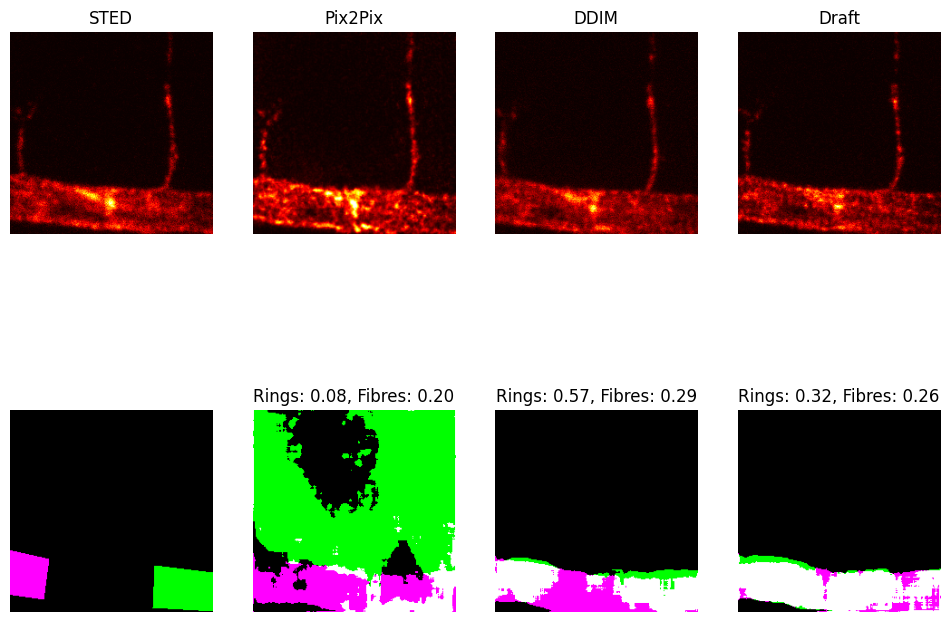

 46%|████▌     | 12/26 [00:37<00:42,  3.02s/it]

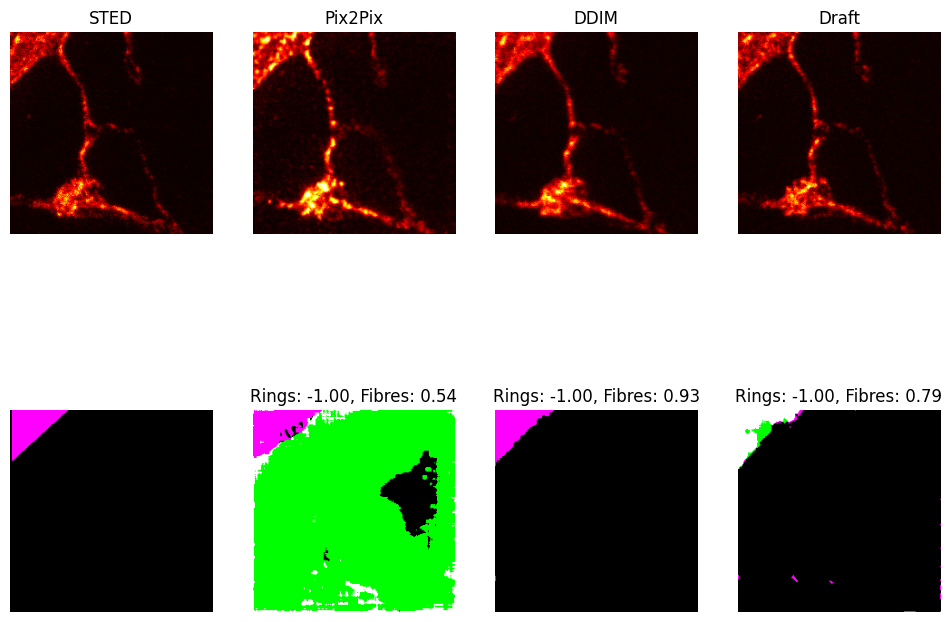

 50%|█████     | 13/26 [00:40<00:38,  2.97s/it]

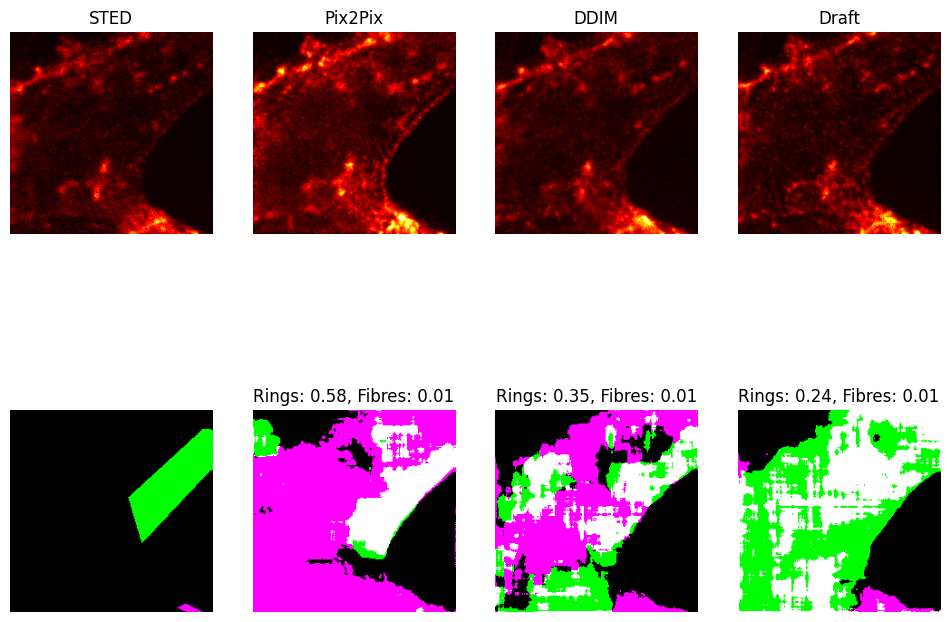

 54%|█████▍    | 14/26 [00:43<00:35,  2.99s/it]

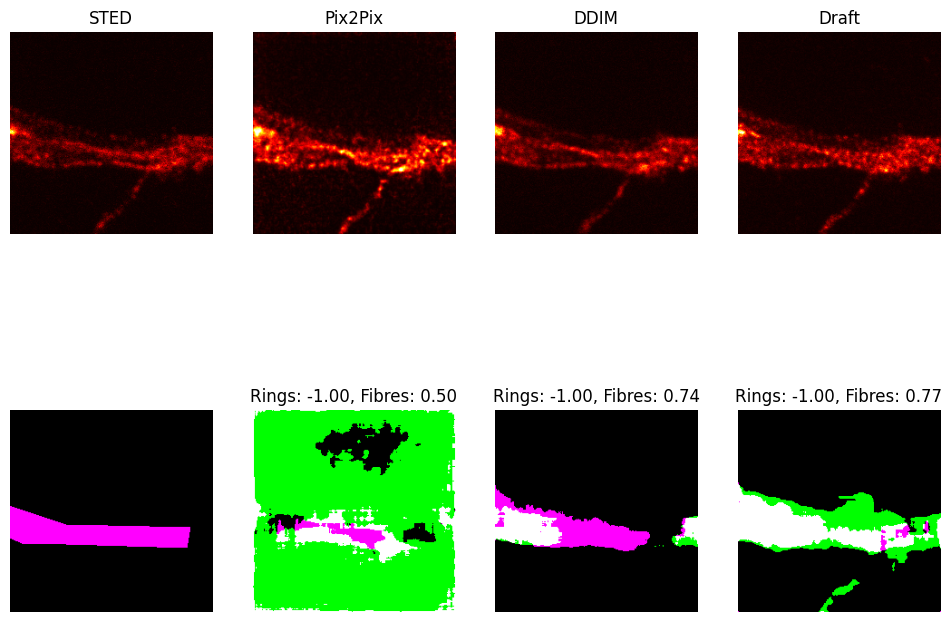

 58%|█████▊    | 15/26 [00:46<00:32,  2.95s/it]

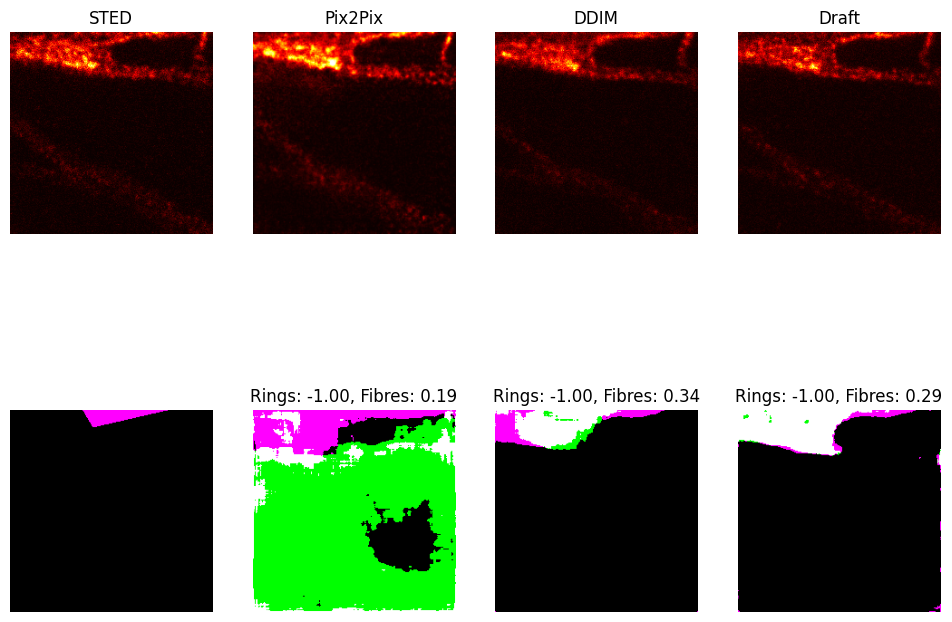

 62%|██████▏   | 16/26 [00:48<00:29,  2.92s/it]

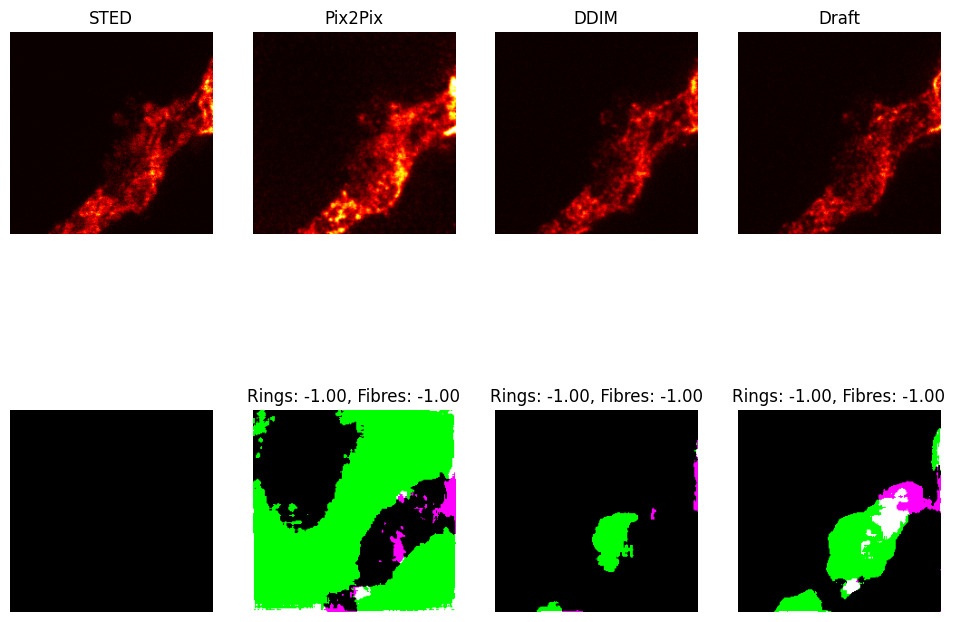

 65%|██████▌   | 17/26 [00:52<00:28,  3.18s/it]

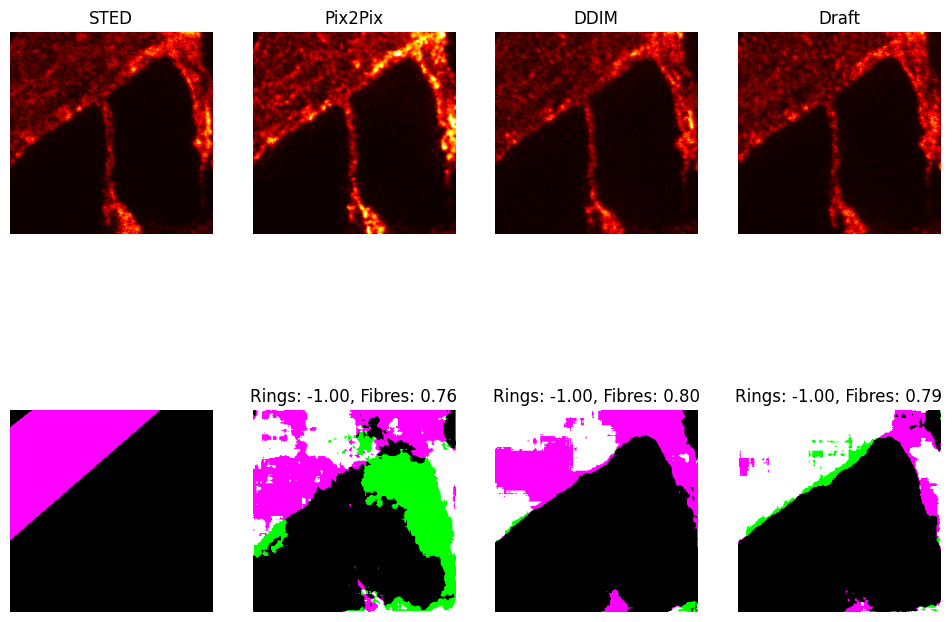

 69%|██████▉   | 18/26 [00:55<00:25,  3.14s/it]

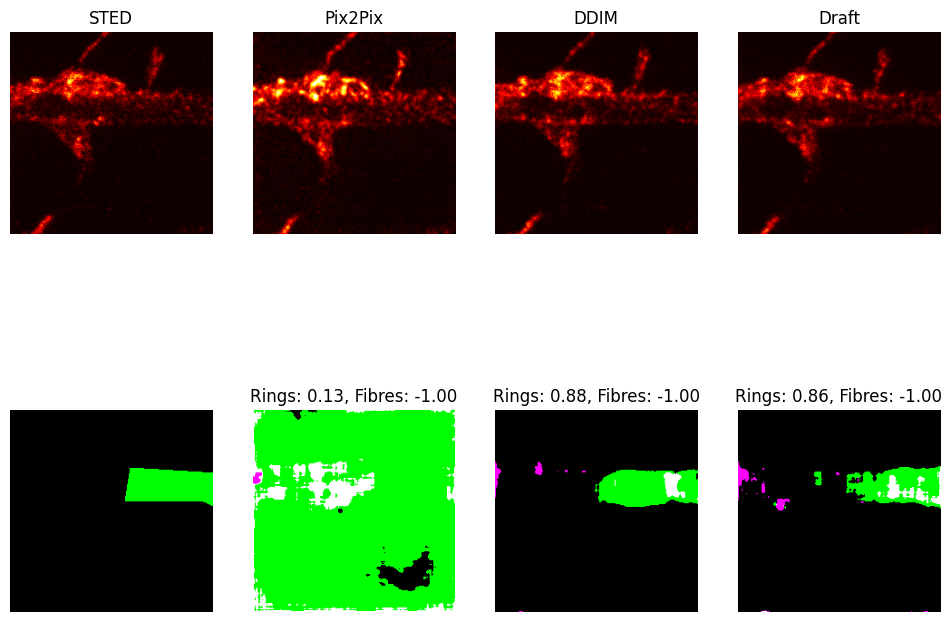

 73%|███████▎  | 19/26 [00:58<00:20,  2.98s/it]

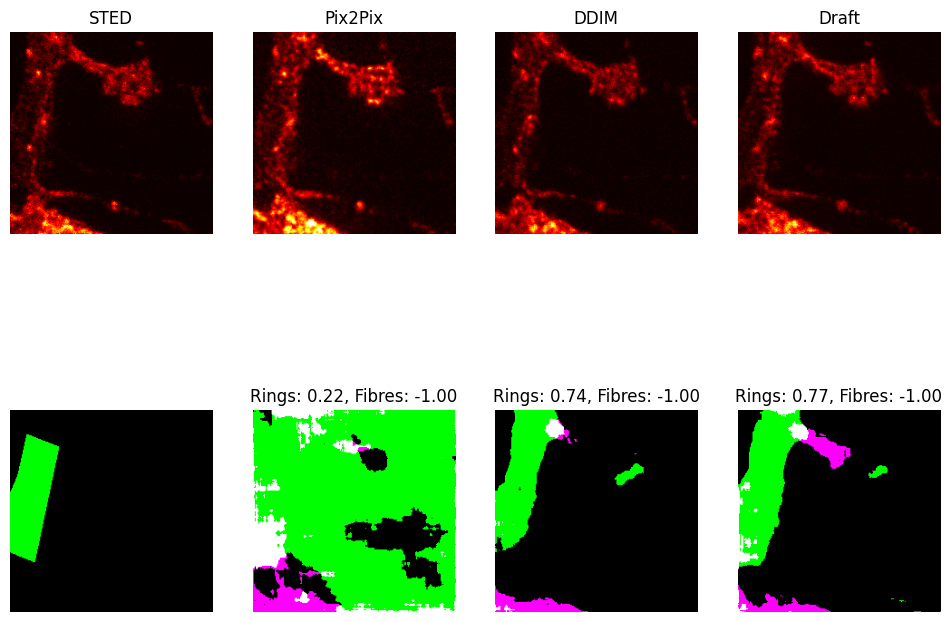

 77%|███████▋  | 20/26 [01:00<00:16,  2.83s/it]

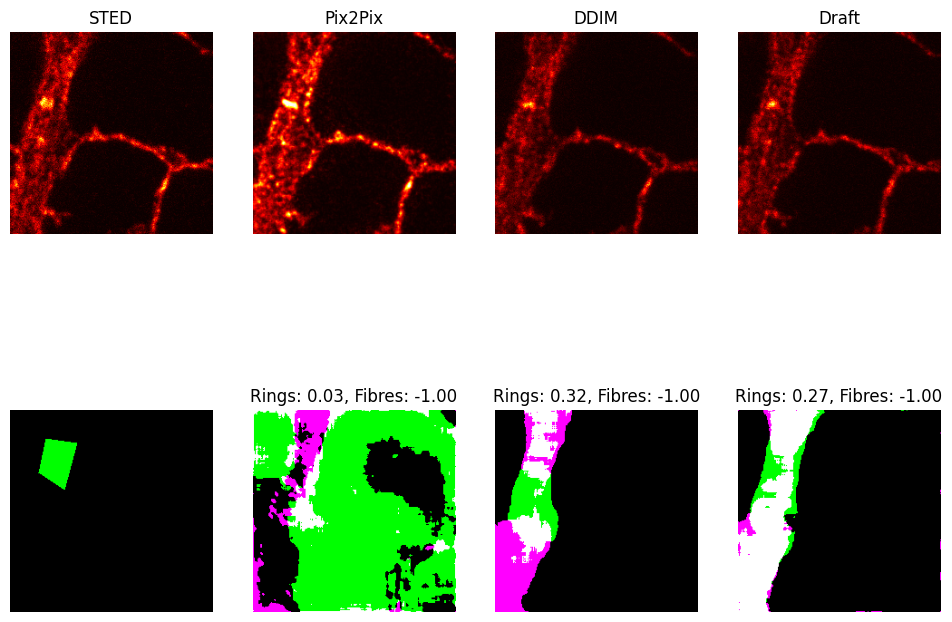

 81%|████████  | 21/26 [01:03<00:14,  2.81s/it]

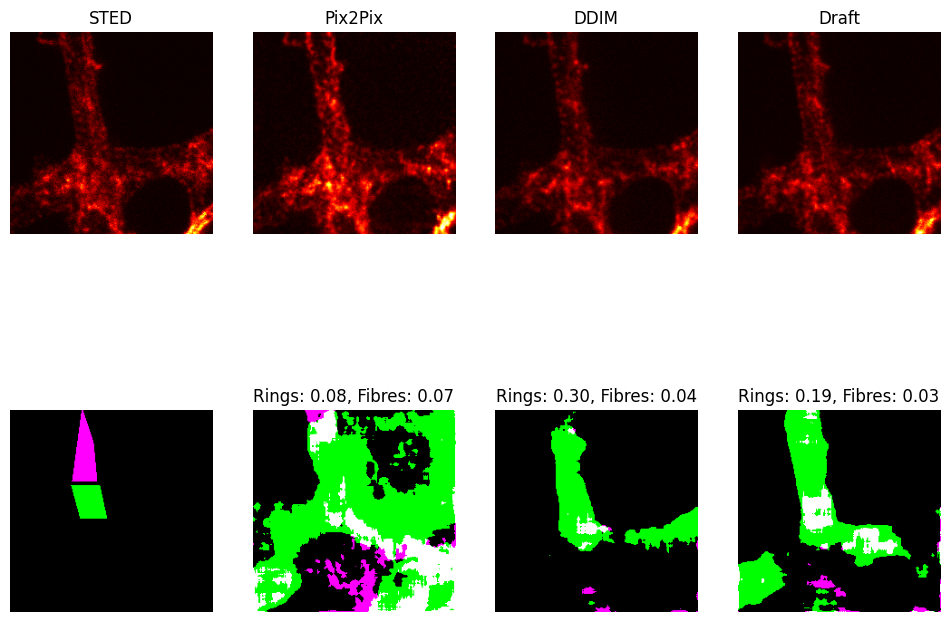

 85%|████████▍ | 22/26 [01:06<00:11,  2.88s/it]

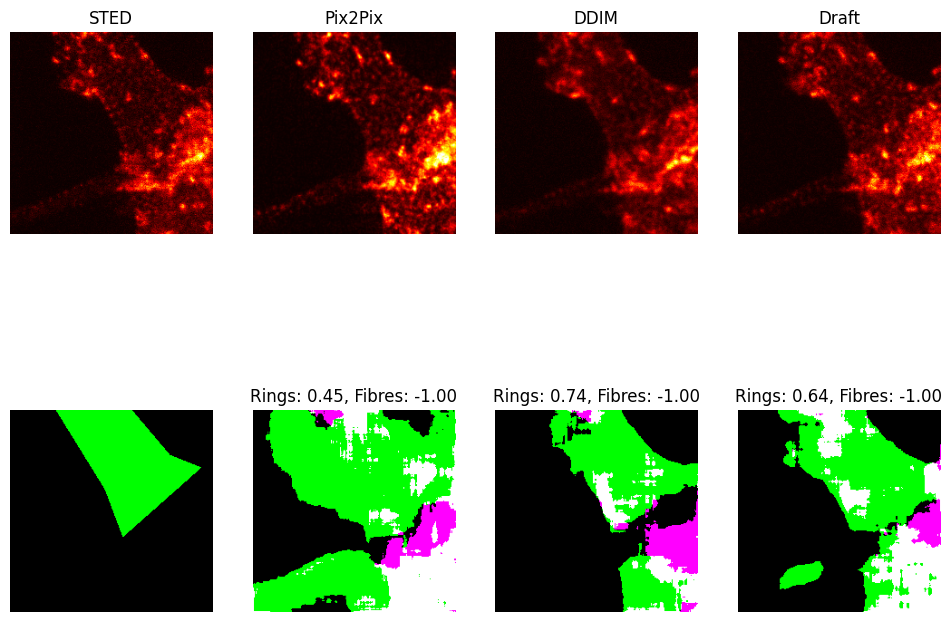

 88%|████████▊ | 23/26 [01:09<00:08,  2.93s/it]

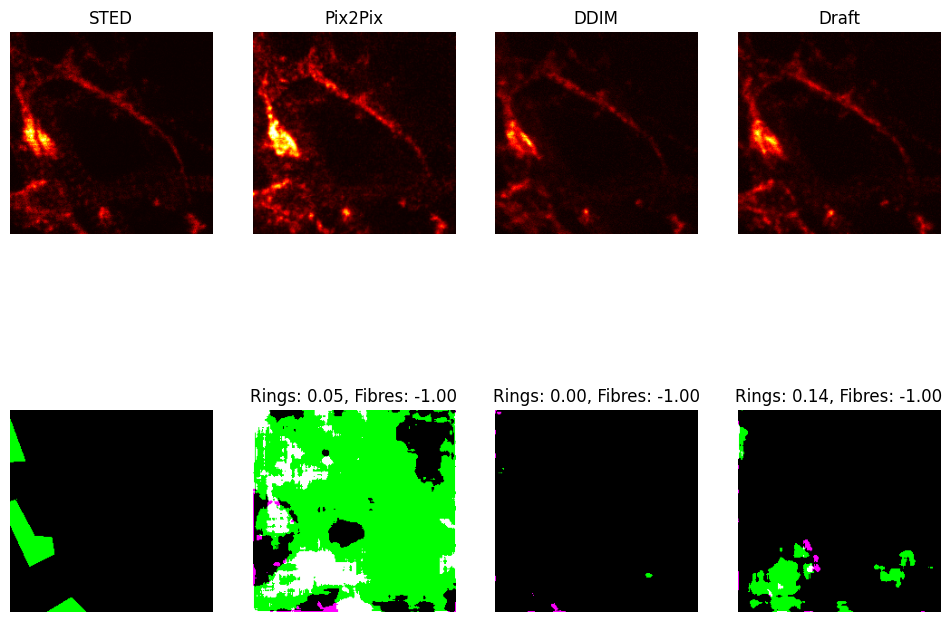

 92%|█████████▏| 24/26 [01:12<00:05,  2.80s/it]

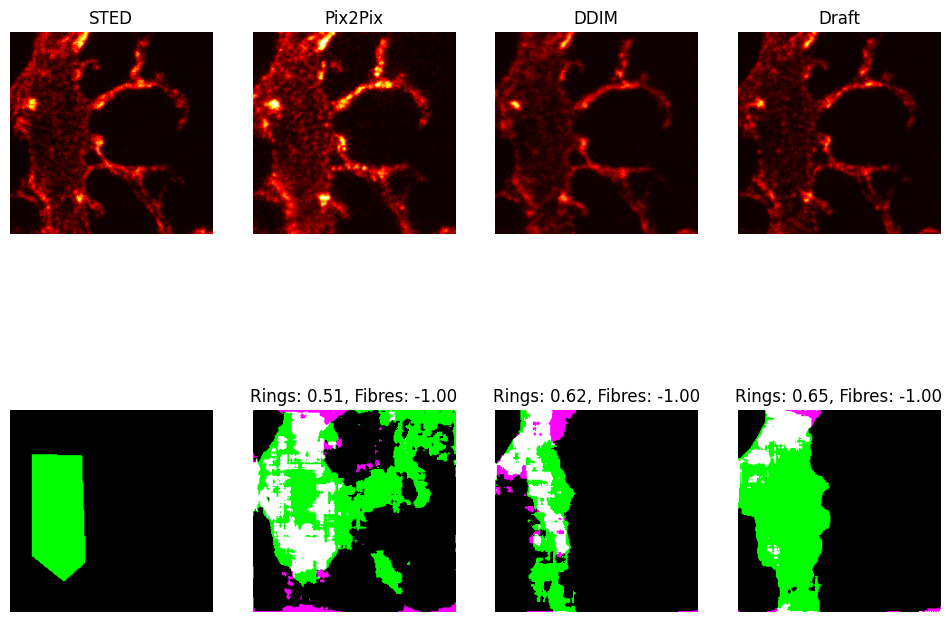

 96%|█████████▌| 25/26 [01:14<00:02,  2.69s/it]

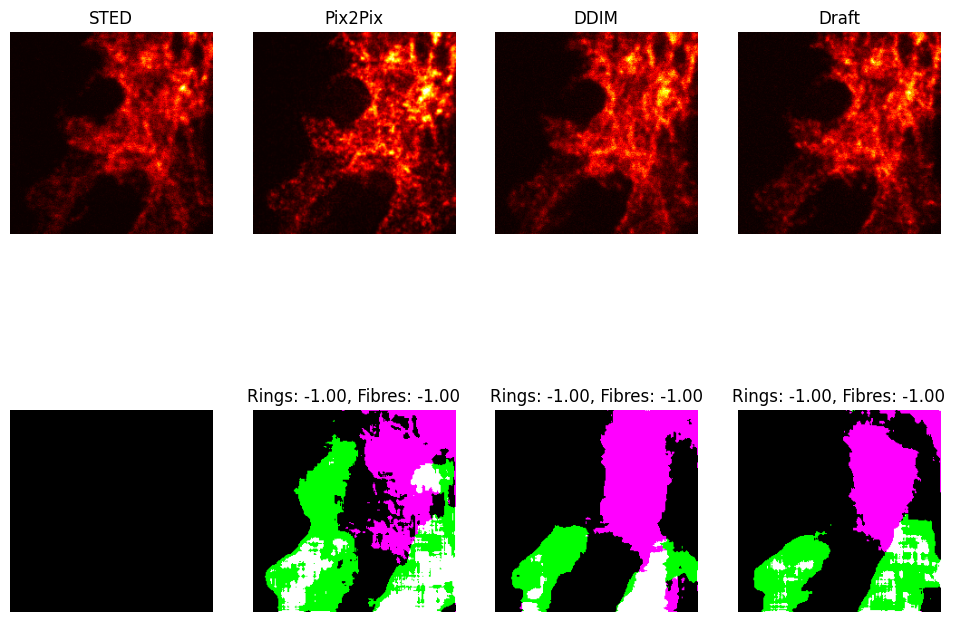

100%|██████████| 26/26 [01:17<00:00,  2.98s/it]


In [4]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr 
from skimage.metrics import mean_squared_error as mse

viz = True

dice_results = {
    "Fibres": {"Pix2Pix": [], "DDIM": [], "Draft": []},
    "Rings": {"Pix2Pix": [], "DDIM": [], "Draft": []},
    "SSIM": {"Pix2Pix": [], "DDIM": [], "Draft": []},
    "PSNR": {"Pix2Pix": [], "DDIM": [], "Draft": []},
    "MSE": {"Pix2Pix": [], "DDIM": [], "Draft": []}
}

for i in trange(26):
    pix2pix_file,ddim_file, draft_file, confocal_file, sted_file, segmentation_file = retrieve_generated(i, RAW_PATH)
    sted = np.clip(tifffile.imread(sted_file), 0, 1)
    ground_truth = tifffile.imread(segmentation_file)
    ground_truth_rgb = make_composite(ground_truth, luts=['green', 'magenta'], ranges=[(0,1), (0,1)])

    pix2pix_gen = np.clip(tifffile.imread(pix2pix_file), 0, 1)
    pix2pix_ssim = ssim(pix2pix_gen, sted, data_range=1)
    pix2pix_psnr = psnr(pix2pix_gen, sted)
    pix2pix_mse = mse(pix2pix_gen, sted)
    dice_results["SSIM"]["Pix2Pix"].append(pix2pix_ssim)
    dice_results["PSNR"]["Pix2Pix"].append(pix2pix_psnr)
    dice_results["MSE"]["Pix2Pix"].append(pix2pix_mse)

    pix2pix_mask = compute_mask(pix2pix_gen, DEVICE) 
    pix2pix_mask[0] = pix2pix_mask[0] > BEST_PIX2PIX_RING_THRESHOLD
    pix2pix_mask[1] = pix2pix_mask[1] > BEST_PIX2PIX_FIBRE_THRESHOLD
    pix2pix_mask_rgb = make_composite(pix2pix_mask, luts=['green', 'magenta'], ranges=[(0,1), (0,1)])
    pix2pix_rings, pix2pix_fibres = compute_dice(pix2pix_mask, ground_truth)
    if pix2pix_fibres != -1:
        dice_results["Fibres"]["Pix2Pix"].append(pix2pix_fibres)
    if pix2pix_rings != -1:
        dice_results["Rings"]["Pix2Pix"].append(pix2pix_rings)

    ddim_gen = np.clip(tifffile.imread(ddim_file), 0, 1)
    ddim_ssim = ssim(ddim_gen, sted, data_range=1)
    ddim_psnr = psnr(ddim_gen, sted)
    ddim_mse = mse(ddim_gen, sted)
 
    dice_results["SSIM"]["DDIM"].append(ddim_ssim)
    dice_results["PSNR"]["DDIM"].append(ddim_psnr)
    dice_results["MSE"]["DDIM"].append(ddim_mse)

    ddim_mask = compute_mask(ddim_gen, DEVICE) 
    ddim_mask[0] = ddim_mask[0] > BEST_DDIM_RING_THRESHOLD
    ddim_mask[1] = ddim_mask[1] > BEST_DDIM_FIBRE_THRESHOLD
    ddim_mask_rgb = make_composite(ddim_mask, luts=['green', 'magenta'], ranges=[(0,1), (0,1)])
    ddim_rings, ddim_fibres = compute_dice(ddim_mask, ground_truth)
    if ddim_fibres != -1:
        dice_results["Fibres"]["DDIM"].append(ddim_fibres)
    if ddim_rings != -1:
        dice_results["Rings"]["DDIM"].append(ddim_rings)
   
    draft_gen = np.clip(tifffile.imread(draft_file), 0, 1)
    draft_ssim = ssim(draft_gen, sted, data_range=1)
    draft_psnr = psnr(draft_gen, sted)
    draft_mse = mse(draft_gen, sted)
    dice_results["SSIM"]["Draft"].append(draft_ssim)
    dice_results["PSNR"]["Draft"].append(draft_psnr)
    dice_results["MSE"]["Draft"].append(draft_mse)

    draft_mask = compute_mask(draft_gen, DEVICE) 
    draft_mask[0] = draft_mask[0] > BEST_DRAFT_RING_THRESHOLD
    draft_mask[1] = draft_mask[1] > BEST_DRAFT_FIBRE_THRESHOLD
    draft_mask_rgb = make_composite(draft_mask, luts=['green', 'magenta'], ranges=[(0,1), (0,1)])
    draft_rings, draft_fibres = compute_dice(draft_mask, ground_truth)
    if draft_fibres != -1:
        dice_results["Fibres"]["Draft"].append(draft_fibres)
    if draft_rings != -1:
        dice_results["Rings"]["Draft"].append(draft_rings)
    
    if viz:
        fig, axs = plt.subplots(2, 4, figsize=(12, 9))
        axs[0, 0].imshow(sted, cmap="hot", vmax=1)
        axs[1, 0].imshow(ground_truth_rgb)
        axs[0, 0].set_title("STED")

        axs[0, 1].imshow(pix2pix_gen, cmap="hot", vmax=1)
        axs[1, 1].imshow(pix2pix_mask_rgb) 
        axs[0, 1].set_title("Pix2Pix")
        axs[1, 1].set_title(f"Rings: {pix2pix_rings:.2f}, Fibres: {pix2pix_fibres:.2f}")

        axs[0, 2].imshow(ddim_gen, cmap="hot", vmax=1)
        axs[1, 2].imshow(ddim_mask_rgb) 
        axs[0, 2].set_title("DDIM")
        axs[1, 2].set_title(f"Rings: {ddim_rings:.2f}, Fibres: {ddim_fibres:.2f}")

        axs[0, 3].imshow(draft_gen, cmap="hot", vmax=1)
        axs[1, 3].imshow(draft_mask_rgb) 
        axs[0, 3].set_title("Draft")
        axs[1, 3].set_title(f"Rings: {draft_rings:.2f}, Fibres: {draft_fibres:.2f}")

        for ax in axs.ravel():
            ax.axis("off")

        plt.show()
        fig.savefig(f"./results/comparison/example_{i}.pdf", dpi=1200, transparent=True, bbox_inches="tight")
        plt.close(fig)


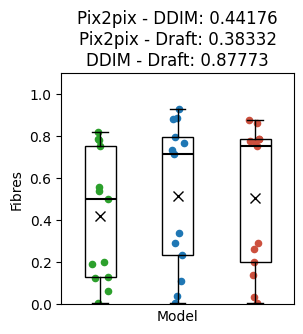

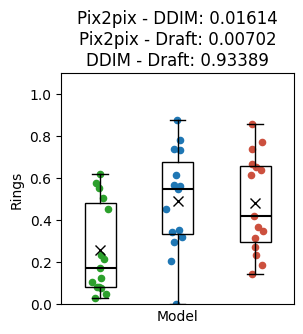

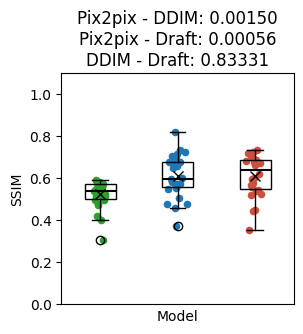

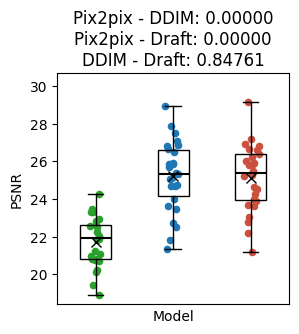

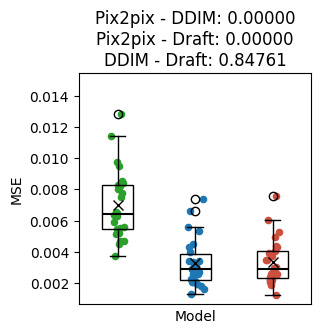

In [17]:
from scipy.stats import mannwhitneyu

def plot_metrics(metrics: dict, metric_key: str) -> None:
    colors = {"Pix2Pix": "tab:green", "DDIM": "tab:blue", "Draft": "#CC503E"}
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    
    c1_data = metrics["Pix2Pix"]
    c2_data = metrics["DDIM"]
    c3_data = metrics["Draft"]
    _, p_value_12 = mannwhitneyu(c1_data, c2_data)
    _, p_value_13 = mannwhitneyu(c1_data, c3_data)
    _, p_value_23 = mannwhitneyu(c2_data, c3_data)
    
    for pos, model_key in enumerate(metrics.keys()):
        data = metrics[model_key]
        x = np.random.normal(loc=pos, scale=0.05, size=len(data))
        ax.scatter(x, data, label=model_key, color=colors[model_key], s=20)
        boxes = ax.boxplot(data, widths=0.40,positions=[pos], showmeans=True, patch_artist=True, medianprops=dict(color='black', linewidth=1.5), meanprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=7, linewidth=1.5, marker='x'),
                           boxprops=dict(facecolor='none'))
        
    #ax.legend()
    ax.set_xlabel("Model")
    ax.set_xticks([]) 
    ax.set_title(f"Pix2pix - DDIM: {p_value_12:.5f}\nPix2pix - Draft: {p_value_13:.5f}\nDDIM - Draft: {p_value_23:.5f}")
    ax.set_ylabel(metric_key)

    ylim = ax.get_ylim()
    
    if metric_key in ["Fibres", "Rings", "SSIM"]:
        ax.set_ylim(0, 1.1)
    elif metric_key == "PSNR":
        y_increment = 1 
        ax.set_ylim(ylim[0], ylim[1] + y_increment)
    elif metric_key == "MSE":
        y_increment = 0.002
        ax.set_ylim(ylim[0], ylim[1] + y_increment)
    else:
        raise ValueError(f"Unknown metric key: {metric_key}")
    
    plt.show()
    fig.savefig(f"./results/metrics/{metric_key}.pdf", dpi=900, transparent=True)
    plt.close(fig)

plot_metrics(dice_results["Fibres"], "Fibres")
plot_metrics(dice_results["Rings"], "Rings")
plot_metrics(dice_results["SSIM"], "SSIM")
plot_metrics(dice_results["PSNR"], "PSNR")
plot_metrics(dice_results["MSE"], "MSE")
